# E-Commerce Customer Churn Prediction

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
import keras
import pickle
from pyforest                      import *
from feature_engine.outliers       import Winsorizer

# library dibawah sebenarnya udah ada di pyforest
from sklearn.model_selection       import train_test_split
from sklearn.feature_selection     import SelectKBest, f_classif
from sklearn.preprocessing         import MinMaxScaler, StandardScaler
from sklearn.preprocessing         import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline              import make_pipeline
from sklearn.compose               import ColumnTransformer
from sklearn.metrics               import (f1_score,
                                           precision_score,
                                           recall_score,
                                           log_loss,
                                           accuracy_score,
                                           classification_report,
                                           ConfusionMatrixDisplay,
                                           confusion_matrix)


In [3]:
from sklearn.ensemble              import StackingClassifier
from sklearn.pipeline              import Pipeline
from sklearn.preprocessing         import StandardScaler
from sklearn_pandas                import DataFrameMapper
from sklearn.ensemble              import AdaBoostClassifier
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.linear_model          import LogisticRegression
from matplotlib.colors             import ListedColormap
from sklearn.linear_model          import SGDClassifier
from sklearn.ensemble              import RandomForestClassifier
from sklearn.linear_model          import SGDClassifier
from sklearn.svm                   import SVC
from sklearn.naive_bayes           import GaussianNB
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.neighbors             import NeighborhoodComponentsAnalysis
from keras.callbacks               import EarlyStopping

In [4]:
X = pd.read_csv('C:/Users/ASUS/kode/Projek/E-Commerce Customer Churn Prediction/X.csv')
y = pd.read_csv('C:/Users/ASUS/kode/Projek/E-Commerce Customer Churn Prediction/y.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
X

,kategori_wilayah,kategori_membership,bergabung_melalui_referral,jenis_penawaran_preferensi,medium_operasi,rata_rata_waktu_dihabiskan,rata_rata_nilai_transaksi,rata_rata_hari_login,poin_di_dompet,menggunakan_diskon_khusus,preferensi_aplikasi_penawaran,umpan_balik
0,Unknown,No Membership,Yes,Without Offers,Unknown,801.13375,38604.69,10.0,627.48,Yes,Yes,Poor Website
1,Unknown,Basic Membership,Yes,Without Offers,Desktop,338.15000,7665.66,17.0,575.97,Yes,No,Poor Customer Service
2,City,Silver Membership,Unknown,Credit/Debit Card Offers,Unknown,235.14000,37671.69,5.0,767.93,Yes,No,Too many ads
3,Village,No Membership,No,Credit/Debit Card Offers,Desktop,56.67000,15678.14,11.0,590.22,No,Yes,Too many ads
4,Town,Silver Membership,Unknown,Gift Vouchers/Coupons,Smartphone,153.99000,8422.68,0.0,722.04,Yes,No,Poor Product Quality
...,...,...,...,...,...,...,...,...,...,...,...,...
36987,Town,Gold Membership,Unknown,Credit/Debit Card Offers,Unknown,199.33000,29455.29,9.0,846.52,Yes,Yes,User Friendly Website
36988,City,Gold Membership,Yes,Without Offers,Desktop,368.50000,27038.47,8.0,835.98,No,Yes,Reasonable Price
36989,Unknown,Gold Membership,Yes,Without Offers,Unknown,272.13000,39305.35,27.0,714.90,Yes,Yes,Poor Customer Service
36990,City,Gold Membership,Yes,Without Offers,Desktop,65.07000,46108.73,6.0,744.99,No,Yes,Poor Website


In [6]:
y

,churn_risk_score
0,1.0
1,1.0
2,0.0
3,1.0
4,0.0
...,...
36987,0.0
36988,0.0
36989,0.0
36990,0.0


In [7]:
X.dtypes

kategori_wilayah                  object
kategori_membership               object
bergabung_melalui_referral        object
jenis_penawaran_preferensi        object
medium_operasi                    object
rata_rata_waktu_dihabiskan       float64
rata_rata_nilai_transaksi        float64
rata_rata_hari_login             float64
poin_di_dompet                   float64
menggunakan_diskon_khusus         object
preferensi_aplikasi_penawaran     object
umpan_balik                       object
dtype: object

### Pipeline

#### Sepertinya kita perlu mengubah data kategorikal menjadi numerikal dengan encoding

In [8]:
num_columns = X.select_dtypes(include=np.number).columns.to_list()
kat_columns = X.select_dtypes(include=['object']).columns.to_list()

<IPython.core.display.Javascript object>

In [9]:
num_columns

['rata_rata_waktu_dihabiskan',
 'rata_rata_nilai_transaksi',
 'rata_rata_hari_login',
 'poin_di_dompet']

In [10]:
kat_columns

['kategori_wilayah',
 'kategori_membership',
 'bergabung_melalui_referral',
 'jenis_penawaran_preferensi',
 'medium_operasi',
 'menggunakan_diskon_khusus',
 'preferensi_aplikasi_penawaran',
 'umpan_balik']

In [11]:
X_final = X.copy()

Jika kita ingat kembali hasil dari visualisasi ddistribusi data kita. Ada beberapa fitur yang mengalami persebaran data yang skew ataupun persebaran normal pada fitur numerikal.

Lalu untuk setiap kolom kategorikal itu akan diterapkan one hot encoding. Dikarenakan data pada setiap fitur tersebut tidaklah sebuah tingkatan namun hanyal sebuah nominal.

In [12]:
normal = ['rata_rata_nilai_transaksi','poin_di_dompet']
skewn = ['rata_rata_hari_login', 'rata_rata_waktu_dihabiskan']

In [13]:
X_final[skewn]

,rata_rata_hari_login,rata_rata_waktu_dihabiskan
0,10.0,801.13375
1,17.0,338.15000
2,5.0,235.14000
3,11.0,56.67000
4,0.0,153.99000
...,...,...
36987,9.0,199.33000
36988,8.0,368.50000
36989,27.0,272.13000
36990,6.0,65.07000


In [14]:
scaler_sc = StandardScaler()

numerical_cols = X_final[normal]
numerical_cols

,rata_rata_nilai_transaksi,poin_di_dompet
0,38604.69,627.48
1,7665.66,575.97
2,37671.69,767.93
3,15678.14,590.22
4,8422.68,722.04
...,...,...
36987,29455.29,846.52
36988,27038.47,835.98
36989,39305.35,714.90
36990,46108.73,744.99


In [15]:
numerical_cols[normal] = scaler_sc.fit_transform(numerical_cols)

In [16]:
numerical_cols2 = X_final[skewn]
numerical_cols2

,rata_rata_hari_login,rata_rata_waktu_dihabiskan
0,10.0,801.13375
1,17.0,338.15000
2,5.0,235.14000
3,11.0,56.67000
4,0.0,153.99000
...,...,...
36987,9.0,199.33000
36988,8.0,368.50000
36989,27.0,272.13000
36990,6.0,65.07000


In [17]:
scaler_mx = MinMaxScaler()

numerical_cols2[skewn] = scaler_mx.fit_transform(numerical_cols2)

In [18]:
numerical_df = pd.concat([numerical_cols, numerical_cols2], axis=1)
numerical_df

<IPython.core.display.Javascript object>

,rata_rata_nilai_transaksi,poin_di_dompet,rata_rata_hari_login,rata_rata_waktu_dihabiskan
0,0.517824,-0.116731,0.224719,1.000000
1,-1.147816,-0.393705,0.382022,0.422089
2,0.467595,0.638481,0.112360,0.293509
3,-0.716455,-0.317082,0.247191,0.070737
4,-1.107061,0.391726,0.000000,0.192215
...,...,...,...,...
36987,0.025255,1.061067,0.202247,0.248810
36988,-0.104857,1.004392,0.179775,0.459973
36989,0.555545,0.353334,0.606742,0.339681
36990,0.921813,0.515131,0.134831,0.081222


In [19]:
kategorikal = X_final[kat_columns]
kategorikal.head()

,kategori_wilayah,kategori_membership,bergabung_melalui_referral,jenis_penawaran_preferensi,medium_operasi,menggunakan_diskon_khusus,preferensi_aplikasi_penawaran,umpan_balik
0,Unknown,No Membership,Yes,Without Offers,Unknown,Yes,Yes,Poor Website
1,Unknown,Basic Membership,Yes,Without Offers,Desktop,Yes,No,Poor Customer Service
2,City,Silver Membership,Unknown,Credit/Debit Card Offers,Unknown,Yes,No,Too many ads
3,Village,No Membership,No,Credit/Debit Card Offers,Desktop,No,Yes,Too many ads
4,Town,Silver Membership,Unknown,Gift Vouchers/Coupons,Smartphone,Yes,No,Poor Product Quality


In [20]:
kategorikal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   kategori_wilayah               36992 non-null  object
 1   kategori_membership            36992 non-null  object
 2   bergabung_melalui_referral     36992 non-null  object
 3   jenis_penawaran_preferensi     36992 non-null  object
 4   medium_operasi                 36992 non-null  object
 5   menggunakan_diskon_khusus      36992 non-null  object
 6   preferensi_aplikasi_penawaran  36992 non-null  object
 7   umpan_balik                    36992 non-null  object
dtypes: object(8)
memory usage: 2.3+ MB


In [21]:
encoder = OneHotEncoder(sparse_output=False)

kategorikal_encoded = encoder.fit_transform(kategorikal)
encoded_columns = encoder.get_feature_names_out(input_features=kat_columns)
kategorikal_encoded_df = pd.DataFrame(kategorikal_encoded, columns=encoded_columns)


<IPython.core.display.Javascript object>

In [22]:
kategorikal_encoded_df.head(3)

,kategori_wilayah_City,kategori_wilayah_Town,kategori_wilayah_Unknown,kategori_wilayah_Village,kategori_membership_Basic Membership,kategori_membership_Gold Membership,kategori_membership_No Membership,kategori_membership_Platinum Membership,kategori_membership_Premium Membership,kategori_membership_Silver Membership,...,preferensi_aplikasi_penawaran_Yes,umpan_balik_No reason specified,umpan_balik_Poor Customer Service,umpan_balik_Poor Product Quality,umpan_balik_Poor Website,umpan_balik_Products always in Stock,umpan_balik_Quality Customer Care,umpan_balik_Reasonable Price,umpan_balik_Too many ads,umpan_balik_User Friendly Website
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [23]:
X_finale = pd.concat([numerical_df, kategorikal_encoded_df], axis=1)
X_finale

<IPython.core.display.Javascript object>

,rata_rata_nilai_transaksi,poin_di_dompet,rata_rata_hari_login,rata_rata_waktu_dihabiskan,kategori_wilayah_City,kategori_wilayah_Town,kategori_wilayah_Unknown,kategori_wilayah_Village,kategori_membership_Basic Membership,kategori_membership_Gold Membership,...,preferensi_aplikasi_penawaran_Yes,umpan_balik_No reason specified,umpan_balik_Poor Customer Service,umpan_balik_Poor Product Quality,umpan_balik_Poor Website,umpan_balik_Products always in Stock,umpan_balik_Quality Customer Care,umpan_balik_Reasonable Price,umpan_balik_Too many ads,umpan_balik_User Friendly Website
0,0.517824,-0.116731,0.224719,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.147816,-0.393705,0.382022,0.422089,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.467595,0.638481,0.112360,0.293509,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.716455,-0.317082,0.247191,0.070737,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.107061,0.391726,0.000000,0.192215,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,0.025255,1.061067,0.202247,0.248810,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36988,-0.104857,1.004392,0.179775,0.459973,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36989,0.555545,0.353334,0.606742,0.339681,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36990,0.921813,0.515131,0.134831,0.081222,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [24]:
X_finale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 38 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   rata_rata_nilai_transaksi                            36992 non-null  float64
 1   poin_di_dompet                                       36992 non-null  float64
 2   rata_rata_hari_login                                 36992 non-null  float64
 3   rata_rata_waktu_dihabiskan                           36992 non-null  float64
 4   kategori_wilayah_City                                36992 non-null  float64
 5   kategori_wilayah_Town                                36992 non-null  float64
 6   kategori_wilayah_Unknown                             36992 non-null  float64
 7   kategori_wilayah_Village                             36992 non-null  float64
 8   kategori_membership_Basic Membership                 36992 non-nul

### Splitting

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_finale,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [26]:
print('Ukuran data latih: ', X_train.shape)
print('Ukuran data test: ', X_test.shape)

Ukuran data latih:  (29593, 38)
Ukuran data test:  (7399, 38)


### Modelling

fungsi untuk evaluasi nanti, kasus klasifikasi

Evaluasi dengan klasifikasi:
- accuracy
- precision
- recall (sensitivity)
- Specificity
- ROC-AUC
- Precision-Recall Curve and AUC
- F-beta score
- Matthews Correlation Coefficient
- Log loss

In [27]:
# y_true itu y_test
def model_report(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    loss = log_loss(y_true, y_pred)
    
    print("accuracy:   {:3f}\nprecision:  {:3f}\nrecall:     {:3f}\nf1-score:   {:3f}\nloss:       {:3f}".
          format(acc, pre, rec, f1, loss))

## Machine Learning

In [28]:
# initiate objek

knn_ball                   = KNeighborsClassifier(n_neighbors=5, algorithm="ball_tree", metric='euclidean')
random_forest              = RandomForestClassifier(max_depth=50, criterion="gini", n_estimators=38)
knn_tree                   = KNeighborsClassifier(n_neighbors=10, algorithm="kd_tree")
decision_tree              = DecisionTreeClassifier(max_depth=17, criterion="entropy")
ada_boost                  = AdaBoostClassifier()
sgd                        = SGDClassifier()
gaussian                   = GaussianNB()
svc                        = SVC()

In [29]:
models = {"KNN Ball"       : knn_ball,
         "KNN Tree"        : knn_tree,
         "Decision tree"   : decision_tree,
         "Random forest"   : random_forest,
         "Ada Boost"       : ada_boost,
         "Gaussian Naive"  : gaussian,
         "SVC"             : svc,
         "SGD"             : sgd}

### Training

#### hasil try and error 😭😭😭😭😭😭😭

In [30]:
def model_report_train(y_true_train, y_pred_train):
    
    acc_train      = accuracy_score(y_true_train, y_pred_train)
    pre_train      = precision_score(y_true_train, y_pred_train)
    rec_train      = recall_score(y_true_train, y_pred_train)
    f1_train       = f1_score(y_true_train, y_pred_train)
    loss_train     = log_loss(y_true_train, y_pred_train)
    
    print("Train Data Metrics:")
    print("accuracy:   {:3f}\nprecision:  {:3f}\nrecall:     {:3f}\nf1-score:   {:3f}\nloss:       {:3f}".
          format(acc_train, pre_train, rec_train, f1_train, loss_train))
    
print("*"*50, "Performa Model ML pada Data Train", "*"*50, "\n")

for nama_model, model in models.items():
    
    model.fit(X_train, y_train)
    y_pred_train    = model.predict(X_train)
    
    print(f"{nama_model}: ")

    model_report_train(y_train, y_pred_train)
    
    print("="*25 + "\n")

************************************************** Performa Model ML pada Data Train ************************************************** 

KNN Ball: 
Train Data Metrics:
accuracy:   0.915284
precision:  0.908827
recall:     0.937488
f1-score:   0.922935
loss:       3.053473

KNN Tree: 
Train Data Metrics:
accuracy:   0.911263
precision:  0.923881
recall:     0.911072
f1-score:   0.917432
loss:       3.198413

Decision tree: 
Train Data Metrics:
accuracy:   0.946136
precision:  0.950228
recall:     0.950228
f1-score:   0.950228
loss:       1.941459

Random forest: 
Train Data Metrics:
accuracy:   0.999662
precision:  0.999501
recall:     0.999875
f1-score:   0.999688
loss:       0.012180

Ada Boost: 
Train Data Metrics:
accuracy:   0.927821
precision:  0.901232
recall:     0.973272
f1-score:   0.935867
loss:       2.601603

Gaussian Naive: 
Train Data Metrics:
accuracy:   0.838712
precision:  0.770374
recall:     1.000000
f1-score:   0.870295
loss:       5.813414

SVC: 
Train Data Metric

### Testing

In [31]:
print("*"*50, "Performa Model ML", "*"*50, "\n")

for nama_model, model in models.items():
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"{nama_model}: ")
    model_report(y_test, y_pred)
    
    print("="*25 + "\n")

************************************************** Performa Model ML ************************************************** 

KNN Ball: 
accuracy:   0.872550
precision:  0.868370
recall:     0.900725
f1-score:   0.884252
loss:       4.593751

KNN Tree: 
accuracy:   0.889445
precision:  0.902353
recall:     0.891973
f1-score:   0.897133
loss:       3.984823

Decision tree: 
accuracy:   0.934721
precision:  0.940160
recall:     0.938985
f1-score:   0.939572
loss:       2.352897

Random forest: 
accuracy:   0.933369
precision:  0.937157
recall:     0.939735
f1-score:   0.938444
loss:       2.401611

Ada Boost: 
accuracy:   0.929720
precision:  0.904253
recall:     0.972993
f1-score:   0.937364
loss:       2.533140

Gaussian Naive: 
accuracy:   0.841195
precision:  0.772903
recall:     1.000000
f1-score:   0.871907
loss:       5.723921

SVC: 
accuracy:   0.926341
precision:  0.919990
recall:     0.945986
f1-score:   0.932807
loss:       2.654925

SGD: 
accuracy:   0.858765
precision:  0.929111

Berdasarkan hasil evaluasi **tiga model terbaik** adalah:
- Random Forest
- Decision Tree
- Ada Boost


Ketiganya memiliki kinerja yang sangat baik pada data uji dengan akurasi yang sangat memuaskan. Random Forest menunjukkan performa paling optimal dengan akurasi 93,6% dengan keseimbangan yang baik antara akurasi, precision, recall, dan f1-score tanpa menunjukkan tanda-tanda overfitting.

## Deep Learning

ANN / Sequential 🙀

Untuk membangun model Neural Network kita akan membangun dari beberapa layer, dimana biasanya terdiri dari tiga layer yaitu input, hidden, dan output layer.

Setiap layer tersebut akan menggunakan beberapa teknik atau fungsi aktivasi yang tujuannya untuk mempelajari dan menangani pola yang kompleks dalam data.

- RElu: ReLU mengonversi semua nilai negatif menjadi nol dan membiarkan nilai positif tidak berubah
- Sigmoid: menghasilkan output dalam rentang 0 hingga 1
- Tanh: tanh menghasilkan output dalam rentang -1 hingga 1
- Softmax: mengubah nilai input menjadi distribusi probabilitas, sehingga output dapat diinterpretasikan sebagai probabilitas relatif dari setiap kelas.
- softplus: digunakan untuk klasifikasi multi-kelas

In [32]:
ann_model = keras.Sequential()

ann_model.add(keras.layers.Dense(units=38, activation="softplus", input_shape=(38,)))
ann_model.add(keras.layers.Dropout(0.1)) #untuk antisipasi overfit

ann_model.add(keras.layers.Dense(units=16, activation="softplus"))
ann_model.add(keras.layers.Dropout(0.2))

ann_model.add(keras.layers.Dense(units=32, activation="softplus"))
ann_model.add(keras.layers.Dropout(0.2))

ann_model.add(keras.layers.Dense(units=16, activation="softplus"))
ann_model.add(keras.layers.Dropout(0.15))

ann_model.add(keras.layers.Dense(units=1, activation="sigmoid")) #output

ann_model.compile(optimizer=keras.optimizers.Adam(0.01), #learning rate
                 loss="mse",
                 metrics=["accuracy"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
ann_latih = ann_model.fit(X_train, y_train,
                         epochs=50,
                         validation_split=0.2,
                         verbose=2)

Epoch 1/50
740/740 - 3s - 5ms/step - accuracy: 0.8351 - loss: 0.1011 - val_accuracy: 0.8667 - val_loss: 0.0843
Epoch 2/50
740/740 - 3s - 3ms/step - accuracy: 0.8546 - loss: 0.0850 - val_accuracy: 0.8834 - val_loss: 0.0832
Epoch 3/50
740/740 - 1s - 2ms/step - accuracy: 0.8992 - loss: 0.0740 - val_accuracy: 0.9177 - val_loss: 0.0610
Epoch 4/50
740/740 - 2s - 2ms/step - accuracy: 0.9148 - loss: 0.0645 - val_accuracy: 0.9127 - val_loss: 0.0618
Epoch 5/50
740/740 - 1s - 2ms/step - accuracy: 0.9186 - loss: 0.0610 - val_accuracy: 0.9243 - val_loss: 0.0585
Epoch 6/50
740/740 - 2s - 2ms/step - accuracy: 0.9209 - loss: 0.0567 - val_accuracy: 0.9260 - val_loss: 0.0490
Epoch 7/50
740/740 - 1s - 2ms/step - accuracy: 0.9221 - loss: 0.0541 - val_accuracy: 0.9274 - val_loss: 0.0468
Epoch 8/50
740/740 - 1s - 2ms/step - accuracy: 0.9239 - loss: 0.0520 - val_accuracy: 0.9277 - val_loss: 0.0472
Epoch 9/50
740/740 - 2s - 2ms/step - accuracy: 0.9232 - loss: 0.0514 - val_accuracy: 0.9299 - val_loss: 0.0474
E

In [34]:
def viz_hasil_churn(ann_latih):

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(ann_latih.history["accuracy"],     label= "Model accuracy")
    ax1.plot(ann_latih.history["val_accuracy"], label= "Valid accuracy")
    ax1.set_title("Model accuracy")
    ax1.set_ylabel("accuracy")
    ax1.set_xlabel("epoch")
    
    ax2.plot(ann_latih.history["loss"],     label= "Model loss")
    ax2.plot(ann_latih.history["val_loss"], label= "Valid loss")
    ax2.set_title("Model loss", )
    ax2.set_ylabel("loss")
    ax2.set_xlabel("epoch")

    ax1.legend()
    ax2.legend()
    
    ax1.spines[['right', 'top']] .set_visible(False)
    ax2.spines[['right', 'top']] .set_visible(False)
    

    fig.suptitle("Model loss & accuracy")
    fig.set_size_inches(12, 6)
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

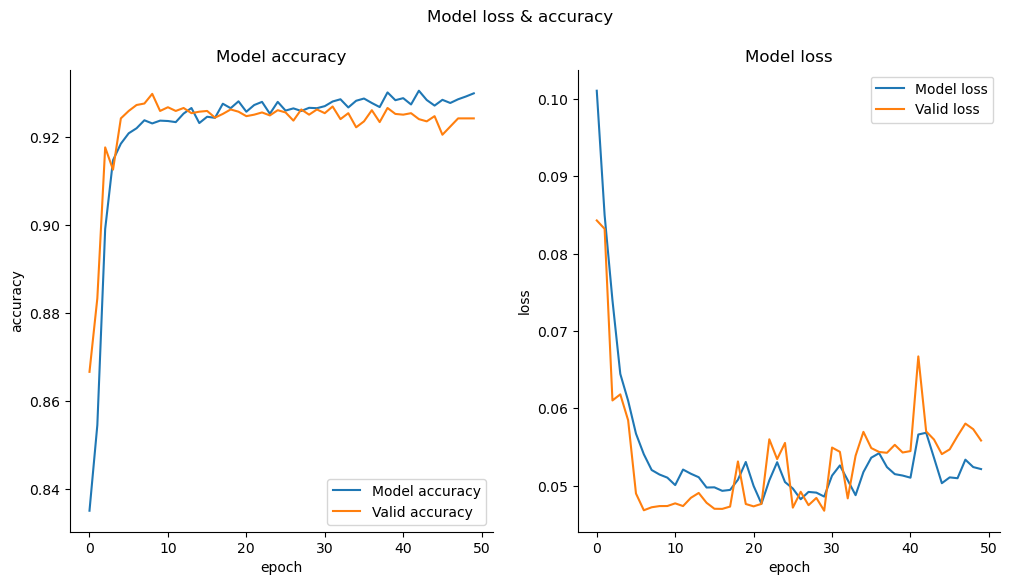

In [35]:
viz_hasil_churn(ann_latih)

Kita bisa lihat hasil evaluasi terhadap prediksi data test sebagai berikut

In [36]:
def pred_report(y_true, y_pred):
    
    # Konversi prediksi yang kontinu menjadi nilai biner (0/1)
    y_pred_bin = np.round(y_pred).astype(int)
    
    # Hitung metrik evaluasi klasifikasi
    acc_ann = accuracy_score(y_true, y_pred_bin)
    pre_ann = precision_score(y_true, y_pred_bin)
    rec_ann = recall_score(y_true, y_pred_bin)
    f1_ann = f1_score(y_true, y_pred_bin)
    loss_ann = log_loss(y_true, y_pred)
    
    print("Accuracy:  {:3f}\nPrecision:  {:3f}\nRecall:  {:3f}\nF1 Score:  {:3f}\nLoss:  {:3f}".
          format(acc_ann, pre_ann, rec_ann, f1_ann, loss_ann))

In [37]:
print("Hasil Evaluasi Model terhadap Prediksi data test menggunakan NN:")
pred_report(y_test, ann_model.predict(X_test, verbose=0))

Hasil Evaluasi Model terhadap Prediksi data test menggunakan NN:


<IPython.core.display.Javascript object>

Accuracy:  0.930396
Precision:  0.963052
Recall:  0.905976
F1 Score:  0.933643
Loss:  0.476278


In [38]:
def plot_confusion_matriks(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tampil = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    tampil.plot(cmap='Greys')
    
    plt.title('Confusion Matrix')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

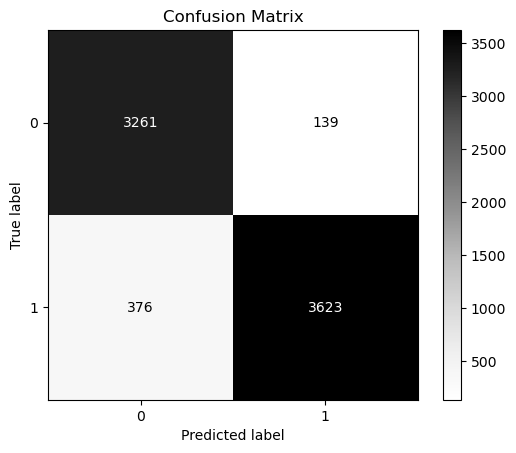

In [39]:
plot_confusion_matriks(y_test, np.round(ann_model.predict(X_test, verbose=0)))

Berdasarkan train, validasi, recall. loss, kita dapat melihat bahwa model ini sudah sesuai atau berada dalam kondisi **good fit**. Tidak ada gradien yang aneh-aneh gitu wkwkwk, yang berarti model bekerja dengan baik.

In [40]:
ann_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 38)                  │           1,482 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 38)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,587 (37.45 KB)

 Trainable params: 3,195 (12.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,392 (24.97 KB)

### Improve/Optimal ANN Model

In [48]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [42]:
ann_model2 = keras.Sequential([
    keras.layers.Dense(units=38, activation="softplus", input_shape=(38,)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=16, activation="softplus"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=32, activation="softplus"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=16, activation="softplus"),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(units=1, activation="sigmoid")
])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
ann_model2.compile(optimizer=keras.optimizers.Adam(0.01),
                  loss="mse",
                  metrics=["accuracy"])

<IPython.core.display.Javascript object>

In [49]:
ann_latih3 = ann_model2.fit(X_train, y_train,
                           epochs=50,
                           callbacks=[early_stopping],
                           validation_split=0.2,
                           verbose=2)

Epoch 1/50
740/740 - 1s - 2ms/step - accuracy: 0.9218 - loss: 0.0536 - val_accuracy: 0.9241 - val_loss: 0.0512
Epoch 2/50
740/740 - 2s - 2ms/step - accuracy: 0.9238 - loss: 0.0524 - val_accuracy: 0.9257 - val_loss: 0.0473
Epoch 3/50
740/740 - 1s - 2ms/step - accuracy: 0.9247 - loss: 0.0526 - val_accuracy: 0.9280 - val_loss: 0.0528
Epoch 4/50
740/740 - 1s - 2ms/step - accuracy: 0.9243 - loss: 0.0560 - val_accuracy: 0.9275 - val_loss: 0.0531
Epoch 5/50
740/740 - 2s - 2ms/step - accuracy: 0.9265 - loss: 0.0553 - val_accuracy: 0.9270 - val_loss: 0.0528
Epoch 6/50
740/740 - 1s - 2ms/step - accuracy: 0.9247 - loss: 0.0553 - val_accuracy: 0.9274 - val_loss: 0.0535
Epoch 7/50
740/740 - 1s - 2ms/step - accuracy: 0.9271 - loss: 0.0550 - val_accuracy: 0.9272 - val_loss: 0.0540
Epoch 8/50
740/740 - 1s - 2ms/step - accuracy: 0.9275 - loss: 0.0545 - val_accuracy: 0.9248 - val_loss: 0.0551
Epoch 9/50
740/740 - 2s - 2ms/step - accuracy: 0.9256 - loss: 0.0554 - val_accuracy: 0.9245 - val_loss: 0.0534
E

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

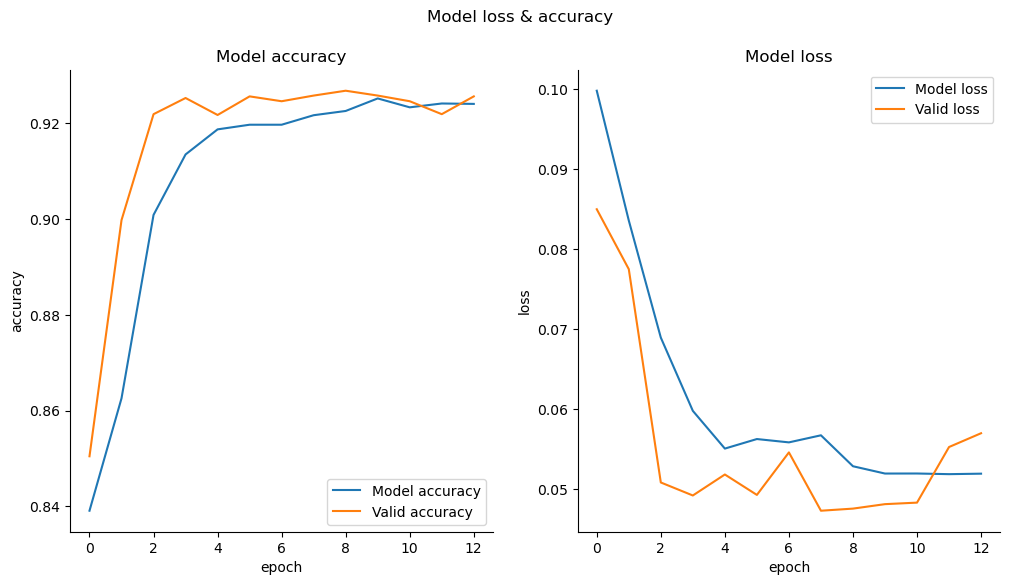

In [50]:
viz_hasil_churn(ann_latih2)

In [51]:
print("Hasil Evaluasi Model terhadap Prediksi data test menggunakan ANN 2:")
pred_report(y_test, ann_model2.predict(X_test, verbose=0))

Hasil Evaluasi Model terhadap Prediksi data test menggunakan ANN 2:


<IPython.core.display.Javascript object>

Accuracy:  0.932423
Precision:  0.954770
Recall:  0.918480
F1 Score:  0.936273
Loss:  0.287877


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

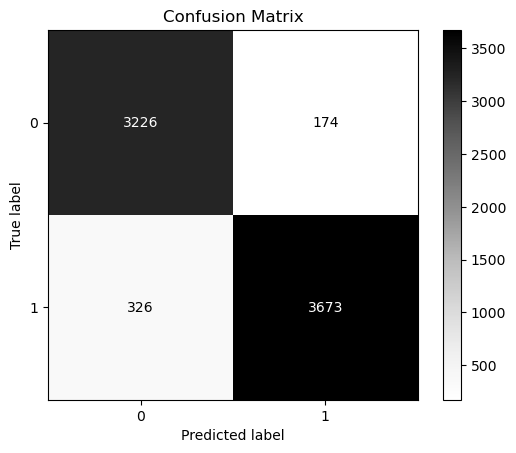

In [52]:
plot_confusion_matriks(y_test, np.round(ann_model2.predict(X_test, verbose=0)))

In [53]:
ann_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 38)                  │           1,482 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 38)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,587 (37.45 KB)

 Trainable params: 3,195 (12.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,392 (24.97 KB)

### Diatas merupakan hasil modelling terbaik yang saya bisa temukan setelah melakukan try dan error.

### Save 4 Best Model
1. Random Forest
2. Decision Tree
3. Ada Boost
4. Artificial Neural Network

Performa Keseluruhan:

Kita dapat melihat bahwa Decision Tree dan Random Forest memiliki nilai akurasi, presisi, recall, dan F1-score yang hampir sama tinggi, sedangkan ANN memiliki akurasi yang sedikit lebih rendah namun presisi yang lebih tinggi. Ada Boost memiliki recall tertinggi, namun dengan nilai presisi yang sedikit lebih rendah. Decision Tree memiliki keunggulan dalam interpretabilitas karena strukturnya yang mirip dengan aturan-aturan keputusan yang mudah dipahami. Random Forest, meskipun lebih kompleks, dapat memberikan beberapa informasi interpretabel tentang fitur-fitur yang penting. ANN sering kali dianggap sebagai "black box" karena kompleksitasnya yang tinggi.

1. Based on Exploratory Data Analysis:
  - Pelanggan tanpa membership dan pelanggan dengan membership basic memiliki risiko churning tertinggi karena kurangnya loyalitas, manfaat yang terbatas, sensitivitas harga, dan keterlibatan yang terbatas.
  - Nasabah yang berisiko churning memiliki rata-rata nilai transaksi yang lebih rendah dibandingkan dengan nasabah yang tidak berisiko churning karena berkurangnya penggunaan.
  - Pelanggan yang berisiko melakukan churning mungkin memiliki saldo poin yang lebih rendah di dompet mereka
  - Kualitas produk yang buruk dapat menyebabkan pelanggan berisiko berpindah karena berkurangnya kepuasan.
  
2. Based on Model Evaluation:
  - Model yang terpilih adalah model sekuensial yang telah diperbaiki dengan model improvement atau menggunakan earlystop. Model ini juga memiliki recall dan precision tertinggi untuk label 0 (nasabah yang berisiko churning) dan memiliki false negative terendah (nasabah tidak berisiko churning diprediksi sebagai nasabah yang berisiko churning).
  
3. Business Insights: 
  - Untuk mempertahankan pelanggan e-commerce yang berisiko berpindah, penting untuk mengatasi faktor-faktor yang berkontribusi terhadap kemungkinan mereka berpindah. Beberapa strategi yang efektif dapat mencakup menawarkan program penghargaan loyalitas, memberikan penawaran dan promosi yang dipersonalisasi, dan iklan yang lebih bagus.


#### Disini aku memutuskan untuk menggunakan model Artificial Neural Network

Pengen aja sekali-kali pake ANN. Tapi nanti jika memang dibutuhkan kita akan menggunakan model seperti Random Forest atau model lainnya.

In [55]:
with open('C:/Users/ASUS/kode/Projek/E-Commerce Customer Churn Prediction/ann_model.pickle', 'wb') as f:
    pickle.dump(ann_model, f)

with open('C:/Users/ASUS/kode/Projek/E-Commerce Customer Churn Prediction/ann_model_improve.pickle', 'wb') as f:
    pickle.dump(ann_model2, f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>